## i. BUSINESS JOB DESCRIPTION

*   Our client is an e-commerce company (_All in one Place_), a multibrand outlet. It profits comes from reseling large quantities of various products by offering low tag prices.

*   After collecting data from their clients database during the period of 1 year, the company's marketing team is analyzing wheter it would be profitable or not to separate it into distinct groups, in order to distinguish those who represent a larger ammount of the company's earnings.

*   The intended group of interest obtained from this clustering analysis will then be called 'Insiders', and will be targeted as eligible clients to win special fidelity programs opportunities.

## ii. THE CHALLENGE

*   I was hired as a Data Scientist consultant, in order to build a model capable of performing such clustering with great accuracy.

*   With the solution, the marketing team can acordingly plan how to target groups of clients in order to optimize profits.

*   In order to understand client's behaviour, we have a database containing information about sales transactions, specifying the products that were bought, their description, quantity, unit price as well as general information about client's physical location (Customer ID, country).

## iii. BUSINESS QUESTIONS

*   It is expected a report as the result of the clsutering analysis, which answers the following questions:

    1.  Which clients are eligible  to take part on the 'Insiders' group ?
    
    2.  How many clients will be selected?

    3.  What are the main features that impacts more the clustering analysis from said clients?

    4.  What is the 'Insiders' group percentage upon the company's total earnings?
    
    5.  What is the expected profit from the 'Insiders' group for the next months?

    6.  What are the main conditions that make one eligible for being on 'Insiders'?

    7.  What are the conditions for one to be excluded from 'Insiders'?

    8.  What guarantees that 'Insiders' group grants more profits to the company compared to the rest of the database?

    9.  Which actions the marketing team can partake to increase profits?


# 0.0 IMPORTS, FUNCTIONS AND DATABASE LOAD

In [1]:
!pip install inflection

In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.9 MB/s eta 0:00:00


In [3]:
!pip install ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 11.1 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=166f67b9a50fbf930bba6c242aeed12a2ab31a2b63cb0185c1204f41cecacb24
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [4]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=b1fb930ae4e9eb573c073dcf3753f2d2f7916e5933b7f2fb5dfdf48502fe5294
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [5]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.0 MB/s eta 0:00:00


## 0.1 Imports

In [6]:
import pandas       as pd
import numpy        as np
import seaborn      as sns
import umap.umap_   as umap
import ipywidgets
import inflection
import optuna
import warnings
import os

from matplotlib         import pyplot as plt
from collections        import Counter
from ydata_profiling    import ProfileReport
from pandasql           import sqldf

from sklearn.preprocessing      import MinMaxScaler, StandardScaler
from sklearn.dummy              import DummyClassifier
from sklearn.ensemble           import RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.cluster            import KMeans
from sklearn.model_selection    import train_test_split, StratifiedKFold, KFold
from sklearn.metrics            import log_loss, silhouette_score

from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from plotly                     import express as px

from imblearn.ensemble          import BalancedRandomForestClassifier
from imblearn.pipeline          import Pipeline
from imblearn.combine           import SMOTEENN
from imblearn.under_sampling    import EditedNearestNeighbours

from IPython.core.display import HTML
from IPython.display      import Image

## 0.2 Helper Functions

In [7]:
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [8]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3 Database load

In [9]:
df_raw = pd.read_csv('datasets/ecommerce.csv', encoding='unicode_escape')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [10]:
#df_raw = pd.read_csv('/home/valquiriaam/repos/PA005/datasets/ecommerce.csv', encoding='unicode_escape')
#df_raw.head()

In [11]:

df1 = df_raw.copy()
df1 = df1.drop(columns=['Unnamed: 8'])

In [12]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 541909
Number of Columns: 8


# 1.0 DATA DESCRIPTION

### 1.3.1 General Description

In [13]:
df1_profile = ProfileReport(df1, title='Profile Report')
df1_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 1.3.2 Data Typification

*   InvoiceNo: Unique Transaction ID

*   StockCode: Item's ID code

*   Description: Item's name

*   Quantity: Quantity of product bought

*   InvoiceDate: Transaction's occurance date

*   UnitPrice:  Product's price per unit

*   CustomerID: Customer's ID code

*   Country: Customer's Country

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [15]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 1.3.3 Missing Data Treatment

In [16]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [17]:
df1 = df1.dropna(subset=['customer_id'])
df1['customer_id'] = df1['customer_id'].astype(int64)

df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [18]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [19]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 406829
Number of Columns: 8


Upon Analyzing Pandas profiling:

*   Customer_id entries with NaN values were be dropped (Not possible to identify the desired client)

### 1.3.4 Numerical and Categorical Data Description

In [20]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [21]:
#invoice number -> Distinct Categorical entries
invoiceno_strings = len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))),'invoice_no'])
negative_quantities = len(num_attributes.loc[num_attributes['quantity'] < 0, 'quantity'])
print(f'Count of Distinct invoice_no strings: {invoiceno_strings} \n' +
      f'Count of entries with negative quantities: {negative_quantities}')

Count of Distinct invoice_no strings: 8905 
Count of entries with negative quantities: 8905


In [22]:
#stock_code -> List of Selected Categorical Entries to further examine
at_least_one_string = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'])
print(f'Total Number of stock codes containing letters: {at_least_one_string}')

cat_stock = cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
print(f'Total Number of string stock_codes : {len(cat_stock)}; Unique Stock Codes:{cat_stock}')

Total Number of stock codes containing letters: 35809
Total Number of string stock_codes : 6; Unique Stock Codes:['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']


In [23]:
df_cat = df1[df1['stock_code'].isin(['POST','D','M', 'PADS', 'DOT', 'CRUK'])]
df_cat.shape

(1774, 8)

In [24]:
#country
cat_attributes['country'].unique()



array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

Upon Analyzing Pandas profiling:

## Numerical Data Premisses

*   Rows with 'unit_price' listed as a negative value (-11062,06) will be deleted. (Not a sale entry, it is descripted as a bad debt adjust)
*   Rows with 'unit_price' listed as 0 (values between 0.0 and 0.01) will be deleted.
*   Rows with quantity listed as negative values are always corrective entries from its previous ones (returned, cancelled entries), and its invoice_number always follows the pattern Cxxxxxx.

#Categorical Data Premises

*   Rows with 'invoice_no' containing any letter (mainly folowing the pattern Cxxxxxx), will be separated as 'return dataset'; This will contain only data from cancelled/returned entries.
*   Rows with Stock Codes that only contains letters (['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']) will be deleted due to lack of information if this is (or not) a selling transaction.


# 2.0 DATA FILTERING

In [25]:
df2 = df1.copy()

In [26]:
# unit_price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# stock_code != ['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

#description
df2 = df2.drop(columns='description', axis=1)

# country != ['Unspecified', 'European Community']
df2 = df2.loc[~df2['country'].isin(['Unspecified', 'European Community'])]

#Quantity: Negative products means product returns; sale cancelled
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 3.0 FEATURE ENGINEERING

*   RFM Model - Recency, Frequency, Monetary




In [27]:
df3 = df2.copy()

In [28]:
#data_reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
                   'unit_price', 'country'], axis=1).drop_duplicates( ignore_index=True )

#Gross Revenue
df2_purchases['revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']
df_monetary = df2_purchases[['customer_id', 'revenue']].groupby(['customer_id']).sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

#Recency -> Reference point adopted as the newest data on dataset ('2017-12-07')
df2_purchases['recency'] = df3['invoice_date'].max() - df2_purchases['invoice_date']
df2_purchases['recency'] = df2_purchases['recency'].dt.days
df_recency = df2_purchases[['customer_id', 'recency']].groupby('customer_id').min('recency').reset_index()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

#Frequency
df_frequency = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_frequency = df_frequency.rename(columns={'invoice_no': 'frequency'})
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')

#Avg Ticket
df_ticket = df2_purchases[['customer_id', 'revenue']].groupby(['customer_id']).mean().reset_index()
df_ticket = df_ticket.rename(columns={'revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_ticket, on='customer_id', how='left')

In [29]:
df_ref.isna().sum()

customer_id     0
revenue        27
recency        27
frequency      27
avg_ticket     27
dtype: int64

#   4.0 EDA (EXPLORATORY DATA ANALYSIS)

In [30]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id    0
revenue        0
recency        0
frequency      0
avg_ticket     0
dtype: int64

## 4.1 Hypothesis Creation

### 4.1.1 Hypothesis Mindmap

4.1.2 Created Hypothesis

## 4.2 EDA

### 4.2.1 Bivariative Analysis

***Validação das Hipóteses/ Feature Engineering/ Mapa de Calor ***

# 5.0 DATA PREPARATION

In [31]:
df5 = df4.copy()

In [32]:
df5.head()

,customer_id,revenue,recency,frequency,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


## 5.1 Numerical Values (Reescaling, Standarziation)

In [33]:
##Standard Scaler
ss = StandardScaler()

df5['revenue'] = ss.fit_transform(df5[['revenue']])
df5['recency'] = ss.fit_transform(df5[['recency']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])


## 5.2 Categorical Values (Encoding)

#   6.0 FEATURE SELECTION

In [34]:
df6 = df5.copy()

# 7.0 HYPERPARAMETER FINE-TUNNING





In [35]:
df7 = df6.copy()

In [36]:
X = df7.drop(columns=['customer_id'])

##  4.1 KMeans

### 4.1.1 Metrics Analysis

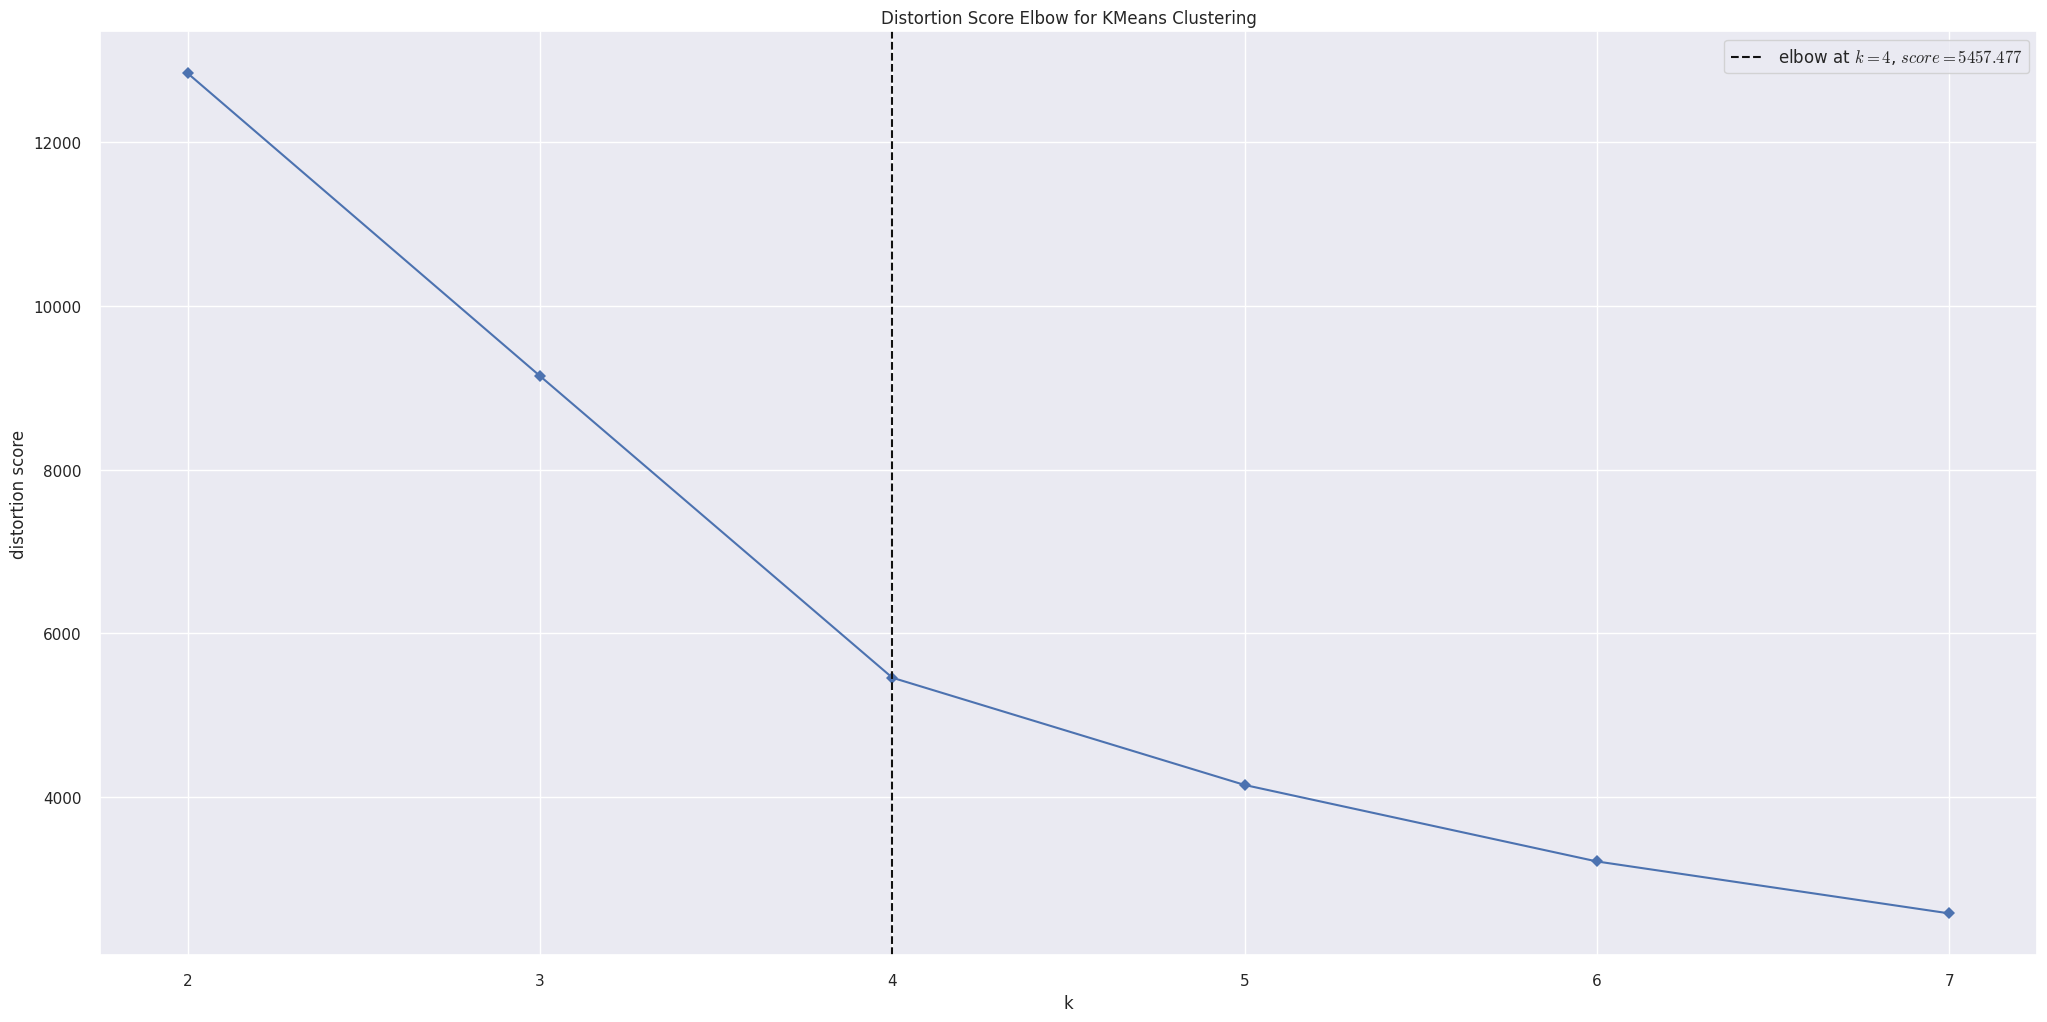

In [37]:
#@title { vertical-output: true}

clusters = [2, 3, 4, 5, 6, 7]


#Model Define
kmeans_model = KElbowVisualizer(KMeans(), k=clusters, init='random',
                                n_init=10, random_state=42, metric='distortion',
                                timings=False)

#Model Training
kmeans_model.fit(X)

#Elbow Method - WSS (Within-Cluster Sum of Squares)
kmeans_model.show();


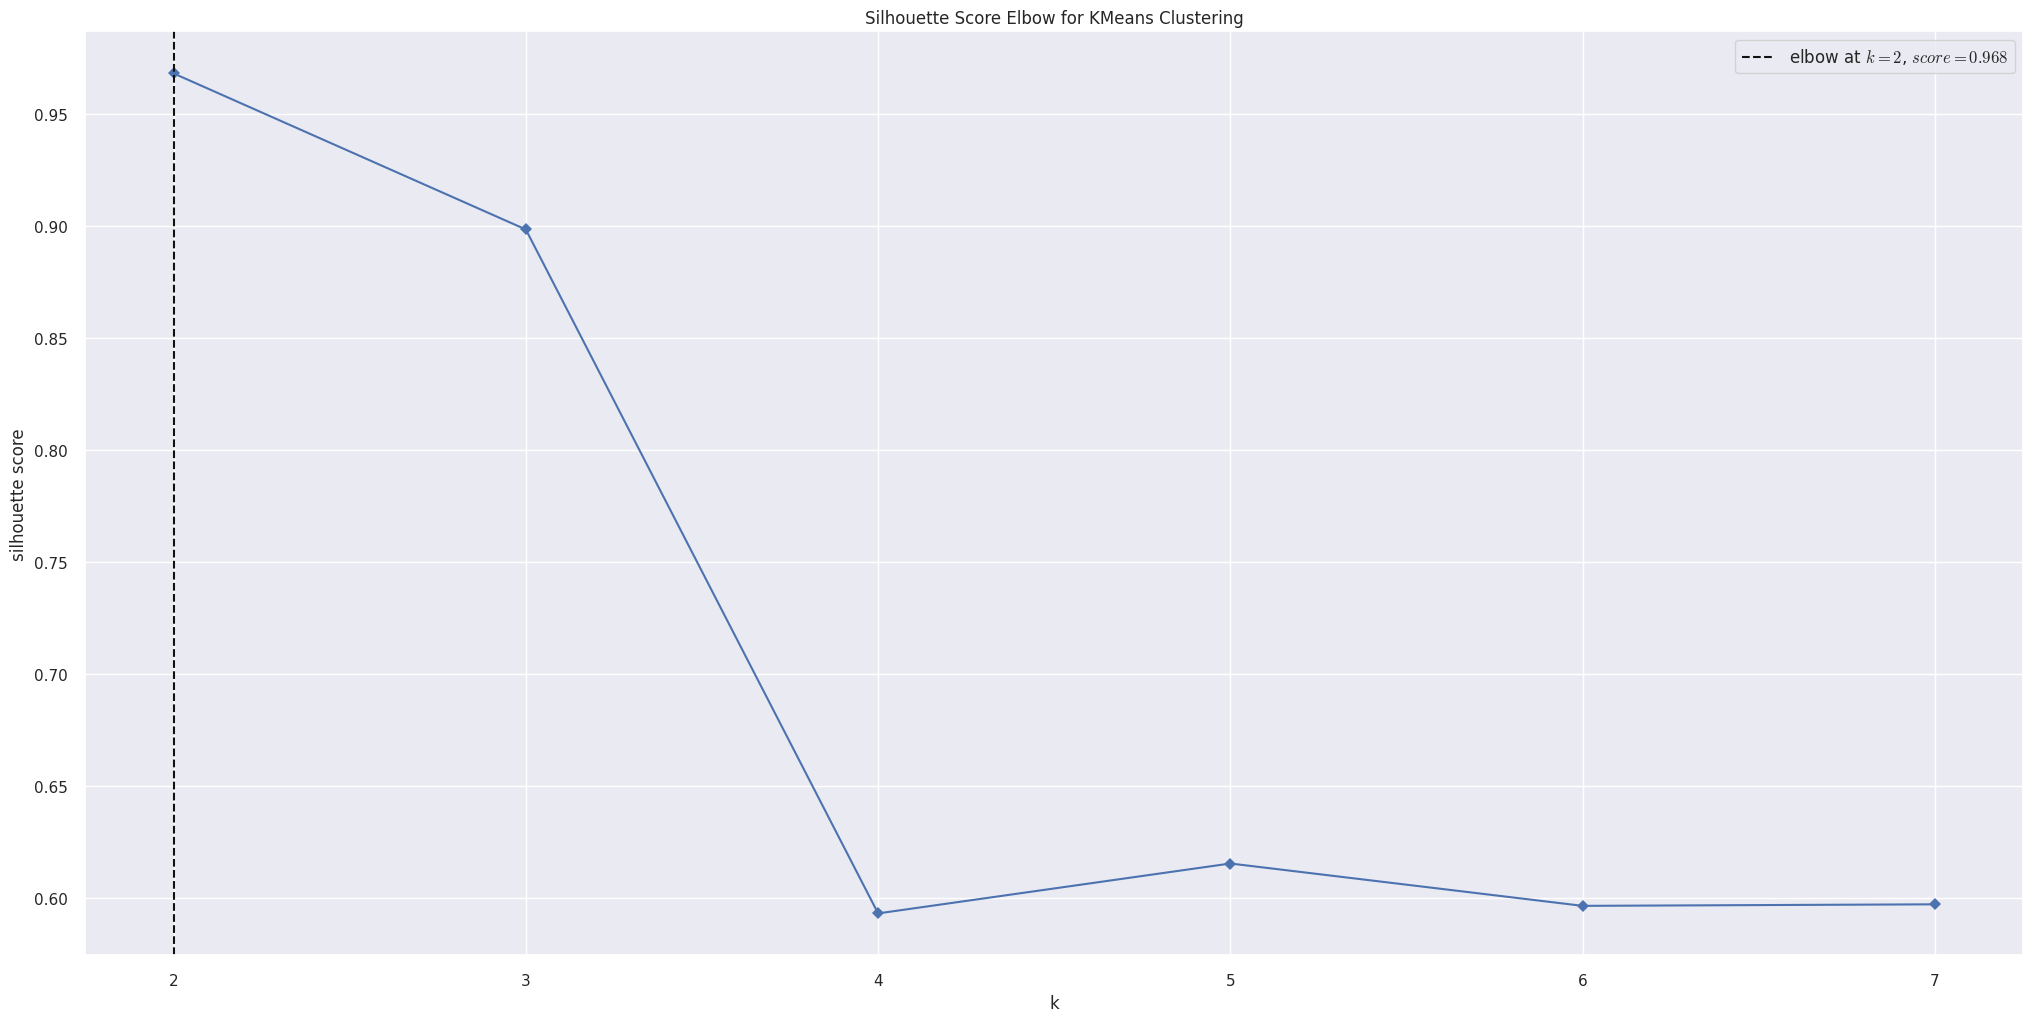

In [38]:
#@title { vertical-output: true}
#Model Define
kmeans_model = KElbowVisualizer(KMeans(), k=clusters, init='random',
                                n_init=10, random_state=42, metric='silhouette',
                                timings=False)

#Model Training
kmeans_model.fit(X)

#Silhouette Score - (Metric value for each cluster)
kmeans_model.show();

### 4.1.2 Silhouette Analysis

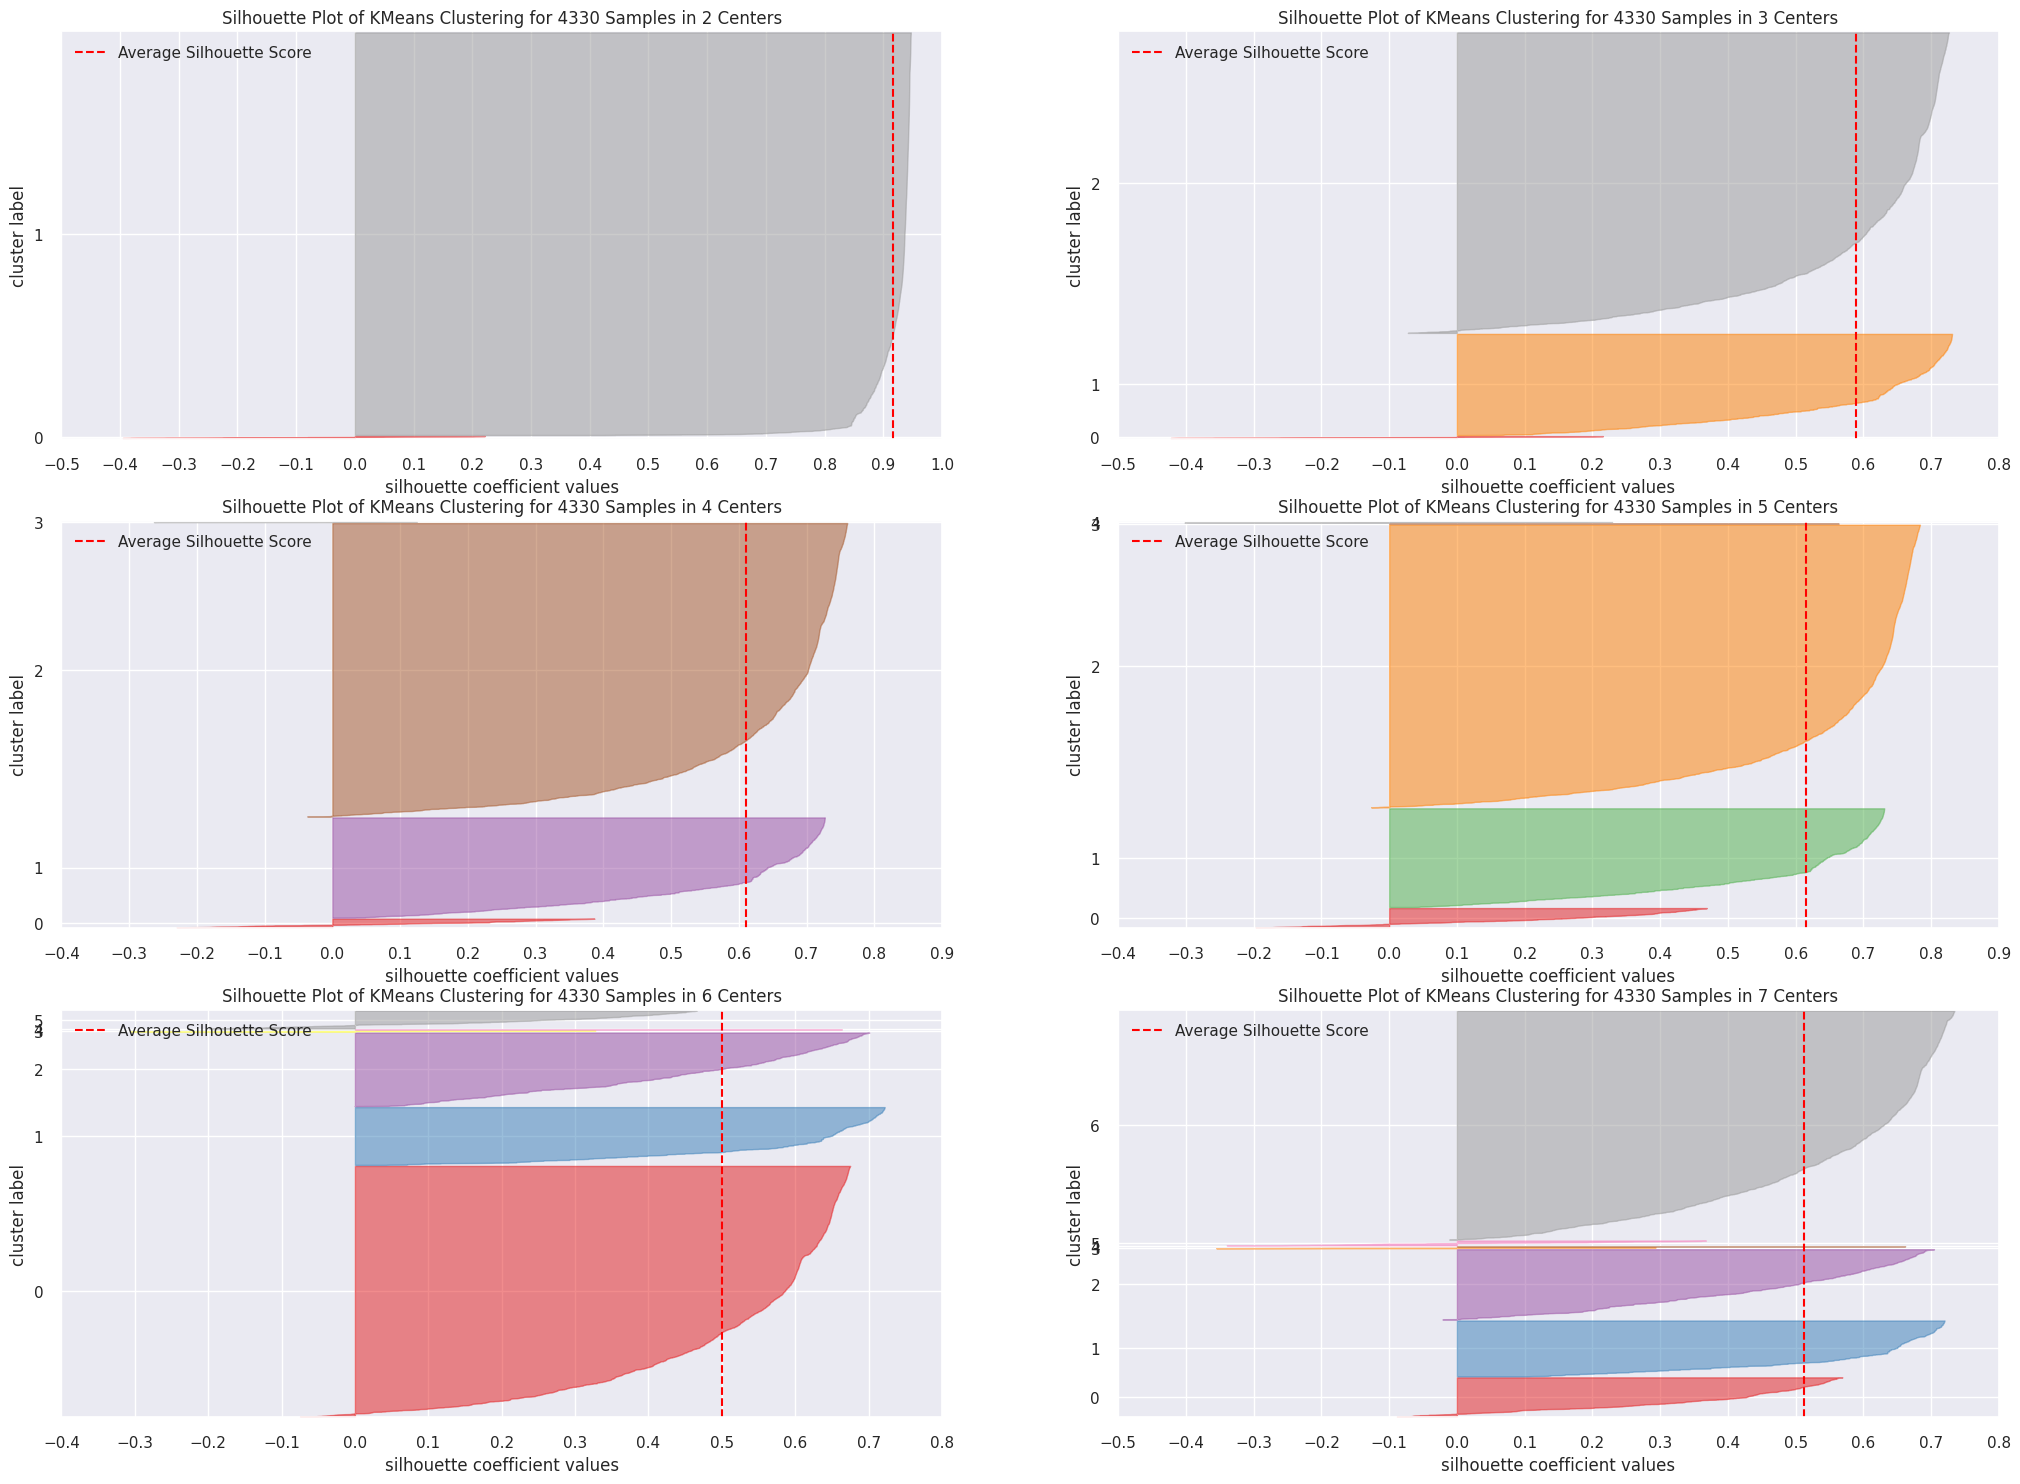

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))


for i in clusters:
    #Model Define
    kmeans = KMeans( n_clusters = i, init='random', n_init=10,
                     max_iter=300, random_state=42)
    q, mod = divmod(i, 2)

    kmeans_model = SilhouetteVisualizer(kmeans, metric='silhouette',
                                        collors='yellowbrick', timings=False,
                                        ax=ax[q-1][mod])

    #Model Training
    kmeans_model.fit(X)

    #Silhouette Score - Silhouette Distribution Visualizer for each cluster
    kmeans_model.finalize();

# 8.0 MODEL TRAINING

In [40]:
k = 3

#Model definition
kmeans_model = KMeans(n_clusters=k, init='random', random_state=42, n_init=10, max_iter=300)

#Model Training
kmeans_model.fit(X)

#Labeling
labels = kmeans_model.labels_

In [41]:
#WSS (Within-Cluster Sum of Square)
print(f'WSS value: {kmeans_model.inertia_}')

#SS (Silhouette Score)
print(f'Silhouette Score: {silhouette_score(X, labels)}')

WSS value: 9404.957923270289
Silhouette Score: 0.5895242294229587


# 9.0 CLUSTER ANALYSIS

In [42]:
df9 = df7.copy()

## 9.1  Visualization Inspection

In [43]:
df9['cluster'] = labels
df9.head()

,customer_id,revenue,recency,frequency,avg_ticket,cluster
0,17850,0.377193,2.791512,3.889210,-0.033939,1
1,13047,0.135388,-0.361004,0.620928,-0.033427,2
2,12583,0.524404,-0.899726,1.405316,-0.026622,2
3,13748,-0.120499,0.028072,0.098003,-0.023244,2
4,15100,-0.128592,2.402435,-0.163459,0.152443,1


In [44]:
#fig = px.scatter_3d(df9, x='recency', y='frequency', z='revenue', color='cluster')
#fig.show()

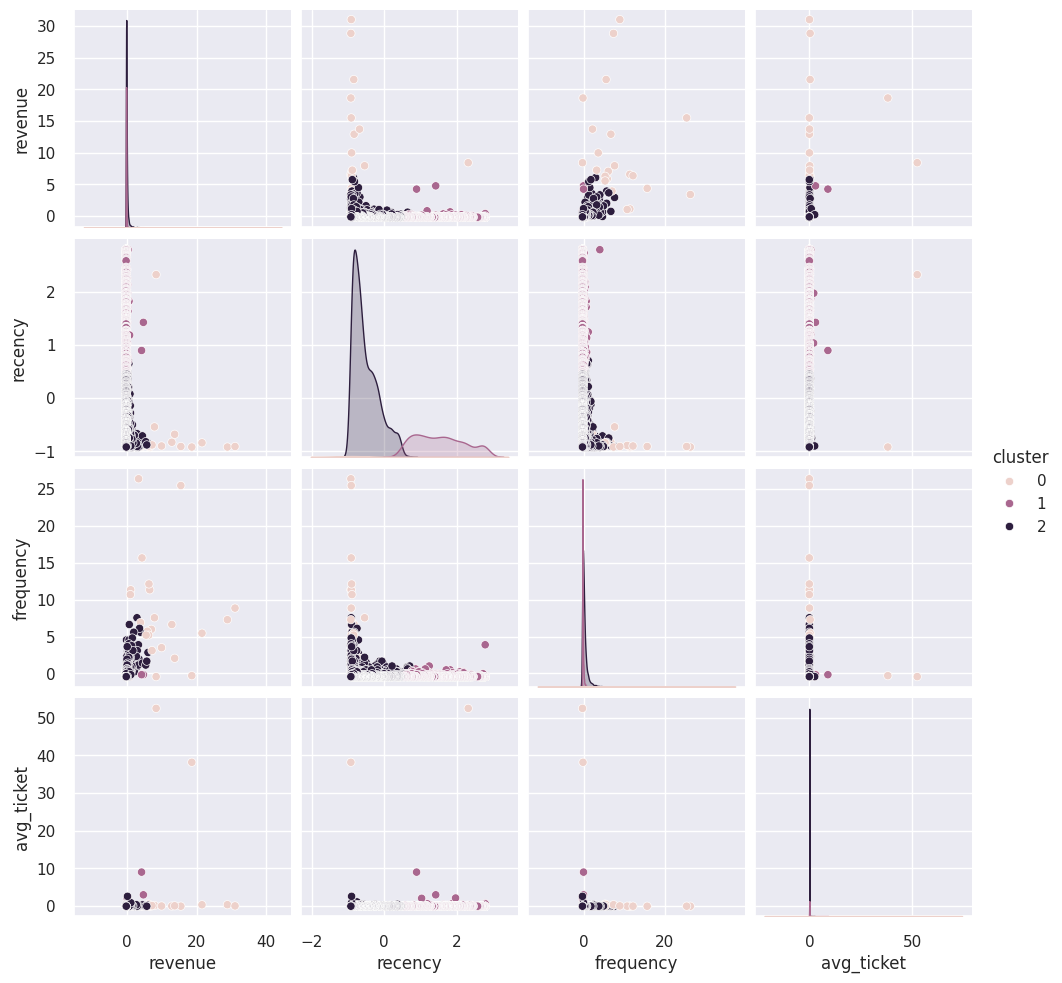

In [45]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

### 9.2 High Dimensionality Analysis (Topological Analysis - UMAP)

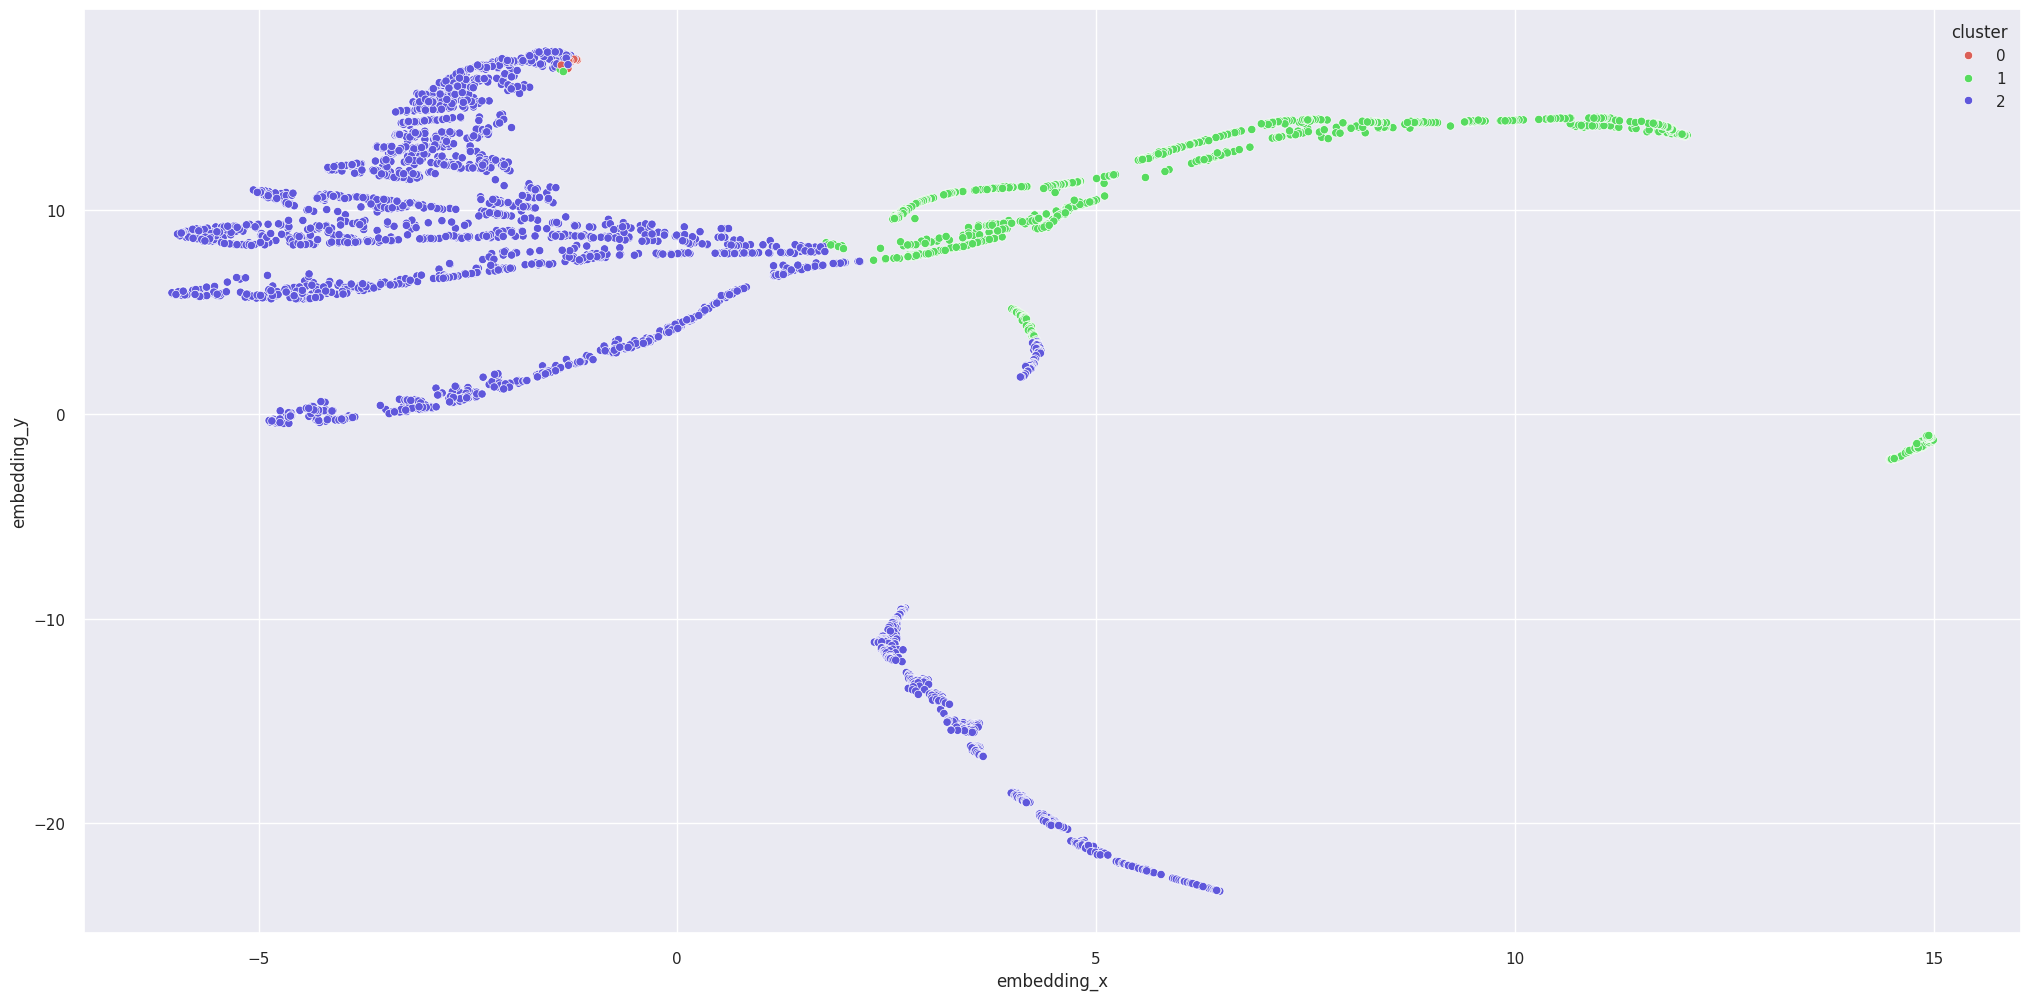

In [46]:
reducer = umap.UMAP(random_state=42, n_neighbors=80)
embedding = reducer.fit_transform(X)

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

sns.scatterplot(x= 'embedding_x', y= 'embedding_y',
                hue='cluster',
                palette= sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

## 9.2 Cluster Profile

In [ ]:
#Number of Customers
df_customer = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_customer = df_customer.rename(columns={'customer_id': 'total_customers'})
df_customer['perc_customers'] = 100*(df_customer['total_customers']/df_customer['total_customers'].sum())

#Avg Revenue
df_revenue = df9[['cluster', 'revenue']].groupby('cluster').mean().reset_index()
df_revenue = df_revenue.rename(columns={'customer_id': 'avg_revenue'})

#Avg Frequency
df_frequency = df9[['cluster', 'frequency']].groupby('cluster').mean().reset_index()
df_frequency = df_frequency.rename(columns={'frequency': 'avg_frequency'})

#Avg Recency
df_recency = df9[['cluster', 'recency']].groupby('cluster').mean().reset_index()
df_recency = df_recency.rename(columns={'recency': 'avg_recency'})


df_profile = pd.merge(df_customer, df_revenue, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_frequency, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_recency, how='left', on='cluster')

df_profile

,cluster,total_customers,perc_customers,revenue,avg_frequency,avg_recency
0,0,22,0.508083,10.335114,8.441036,-0.722419
1,1,1086,25.080831,-0.164555,-0.350287,1.538960
2,2,3222,74.411085,-0.015104,0.060431,-0.513786


## Cluster 00: (Candidato à Insider)

*   Número de Customers = 6 (0.13% da base de dados)
*   Recência Média = 7 dias
*   Compras em Média = 89 compras
*   Receita Média = $182181,98

## Cluster 01: (Estudo de Viabilidade ao programa Insider)

*   Número de Customers = 31 (0.70% da base de dados)
*   Recência Média = 13 dias
*   Compras em Média =  53 compras
*   Receita Média = $40543,51

## Cluster 02: (Não Selecionados)

*   Número de Customers = 4335 (99,15% da base de dados)
*   Recência Média = 92 dias
*   Compras em Média = 5 compras
*   Receita Média = $1372,57



#   10.0 DEPLOY TO PRODUCTION